## Importing the necessary libraries

In [123]:
import numpy as np
import pandas as pd

In [124]:
!pip install transformers --quiet

In [125]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Preprocessing 

In [127]:
# remove hashtags
def hashtags(text):
    hash = re.findall(r"#(\w+)", text)
    return hash
    
# remove retweet username and tweeted at @username
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    # remove tweeted at
    return tweet

# remove links
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def clean_html(text):
    html = re.compile('<.*?>')#regex
    return html.sub(r'',text)

# remove non ascii character
def non_ascii(s):
    return "".join(i for i in s if ord(i)<128)

def lower(text):
    return text.lower()

# remove stopwords
def removeStopWords(str):
    #select english stopwords
    cachedStopWords = set(stopwords.words("english"))
    #add custom words
    cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
    #remove stop words
    new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
    return new_str

# remove email address
def email_address(text):
    email = re.compile(r'[\w\.-]+@[\w\.-]+')
    return email.sub(r'',text)

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

# remove digits and special characters
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    #when the ^ is on the inside of []; we are matching any character that is not included in this expression within the []
    return re.sub(pattern, '', text)

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_(tweet):
    tweet = re.sub('([_]+)', "", tweet)
    return tweet

## Loading the SMS spam collection dataset

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
path = "/content/drive/MyDrive/Data/"
names = ["class", "sms"]
df = pd.read_csv(path + "SMSSpamCollection.fwf", names=names, sep='\t')
df.sample(10)

,class,sms
551,ham,"Imagine you finally get to sink into that bath after I have put you through your paces, maybe even having you eat me for a while before I left ... But also imagine the feel of that cage on your cock surrounded by the bath water, reminding you always who owns you ... Enjoy, my cuck"
3787,ham,Wat r u doing?
1949,ham,I cant pick the phone right now. Pls send a message
1776,ham,Did u see what I posted on your Facebook?
3363,ham,No messages on her phone. I'm holding it now
992,ham,Hi im having the most relaxing time ever! we have to get up at 7am every day! was the party good the other night? I get home tomorrow at 5ish.
4064,ham,How are you. Its been ages. How's abj
804,spam,You have won a guaranteed £200 award or even £1000 cashto claim UR award call free on 08000407165 (18+) 2 stop getstop on 88222 PHP. RG21 4JX
3021,ham,I thank you so much for all you do with selflessness. I love you plenty.
2196,ham,"V-aluable. A-ffectionate. L-oveable. E-ternal. N-oble. T-ruthful. I-ntimate. N-atural. E-namous. Happy ""VALENTINES DAY"" in advance"


## Feature Engineering

In [130]:
df.shape

(5572, 2)

In [131]:
df.isna().sum()

class    0
sms      0
dtype: int64

In [132]:
df.duplicated().sum()

403

In [133]:
df = df.drop_duplicates()
df.shape

(5169, 2)

In [134]:
df = df.dropna()
df.shape

(5169, 2)

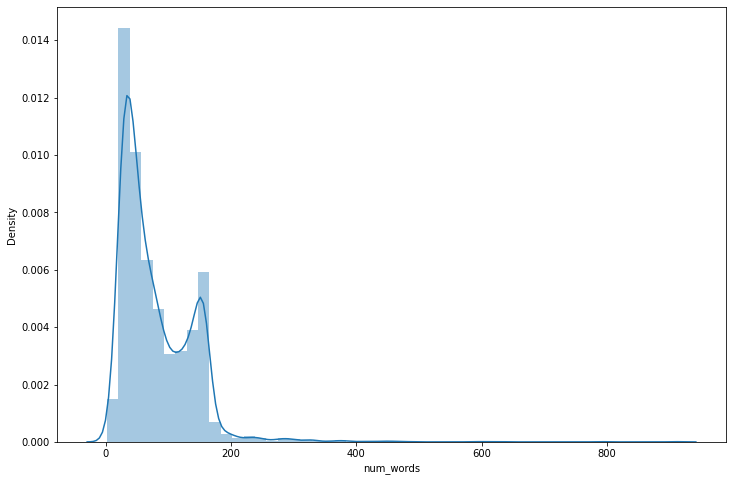

In [135]:
df['num_words'] = df['sms'].apply(len)
sns.distplot(df.num_words);

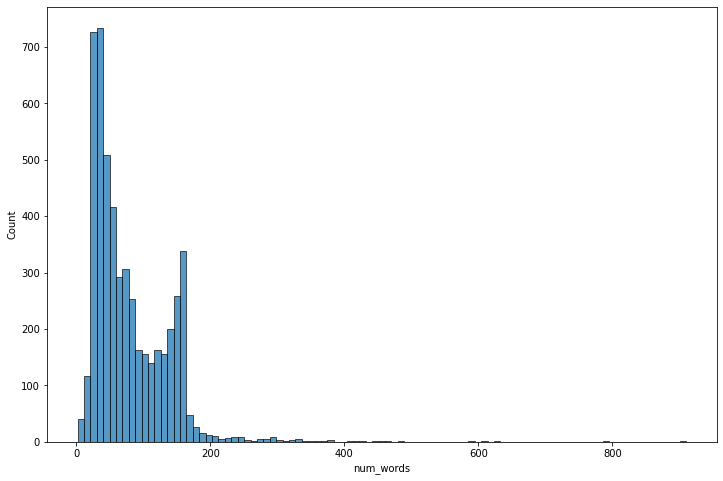

In [136]:
sns.histplot(df.num_words);

In [137]:
print(f"Average number of words in an tweet:{df.num_words.mean():.2f}")

Average number of words in an tweet:79.34


In [138]:
df.num_words.describe()

count    5169.000000
mean       79.344554
std        58.437457
min         2.000000
25%        36.000000
50%        61.000000
75%       119.000000
max       910.000000
Name: num_words, dtype: float64

In [139]:
max_len = 67

## Text Preprocessing

In [140]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [141]:
preprocessed_df = text_preprocess(df,'sms')

In [142]:
preprocessed_df.sample(10)

,class,sms,num_words
2491,ham,dun b sad it s over dun thk abt already concentrate ur papers k,81
3045,ham,let know changes next hrs even appendix age range however impossible chill let know hrs,169
3580,ham,multiply numbers independently count decimal points then division push decimal places showed you,126
500,ham,dear reache room,23
3617,ham,can please ask macho price range is want something new used plus interfued blackberry bold lt gt bb,155
935,spam,dear matthew please call landline complimentary lux tenerife holiday cash await collection ppm sae tcs box skxh,158
1458,spam,claire havin borin time alone u wanna cum nite chat hope c u luv claire xx calls minmoremobsemspoboxpowa,153
4160,ham,now got tv watch meh u work today,40
4533,ham,ok days making dinner tonite am invited,73
2389,ham,wiskey brandy rum gin beer vodka scotch shampain wine kudi yarasu dhina vaazhthukkal,89


## Splitting the dataset into training and test sets

In [143]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.2,random_state=26,shuffle=True,stratify=preprocessed_df["class"])

In [144]:
train_df.sample(5)

,class,sms,num_words
4651,ham,finally happened aftr decades beer cheaper petrol the goverment expects us drink but drive,135
1420,ham,speak feel words better silence gud mrng,78
1028,ham,are around still asleep v,43
616,ham,happy valentines day know early hundreds handsomes beauties wish thought finish aunties uncles st,145
114,spam,gent we trying contact you last weekends draw shows prize guaranteed call claim code k valid hrs only ppm,158


In [145]:
train_df.shape, test_df.shape 

((4135, 3), (1034, 3))

## Encode `Sentiment` as class

In [146]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df["class"])
y_test = encoder.fit_transform(test_df["class"])

In [147]:
print(y_train[0:5])

[0 0 1 0 0]


## Loading the pretrained Tokenizer class and the pretrained ROBERTA-BASE transformer model

In [148]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased",from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Performing text tokenization

In [149]:
X_train = tokenizer(text=train_df["sms"].tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)
X_test = tokenizer(text=test_df["sms"].tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

In [150]:
train_df["sms"][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [151]:
X_train['input_ids'][0]

<tf.Tensor: shape=(67,), dtype=int32, numpy=
array([  101,  6798,  1324,  1821, 19353,  1146,  1380,  2068,  1198,
        1400,  2653, 23372,  4164,  5871,  1964, 11891,  1179,  1549,
         170,  2653,  3606,  1139,  1250,  1138, 11891,  1179,  1189,
        3073, 21050,  2528,  6944, 24682,   178,  1821,  2296, 13465,
         181,  1358,  1964,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)>

In [152]:
X_train['attention_mask'][0]

<tf.Tensor: shape=(67,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)>

## Fine-tuning the BERT transformer model architecture

In [153]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [154]:
embeddings = bert(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)

output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)

output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)

output = Dense(units=256,activation='relu')(output)
output = Dropout(0.1)(output)

output = Dense(units=128,activation='relu')(output)
output = Dense(units=2,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

## Visualizing the model architecture

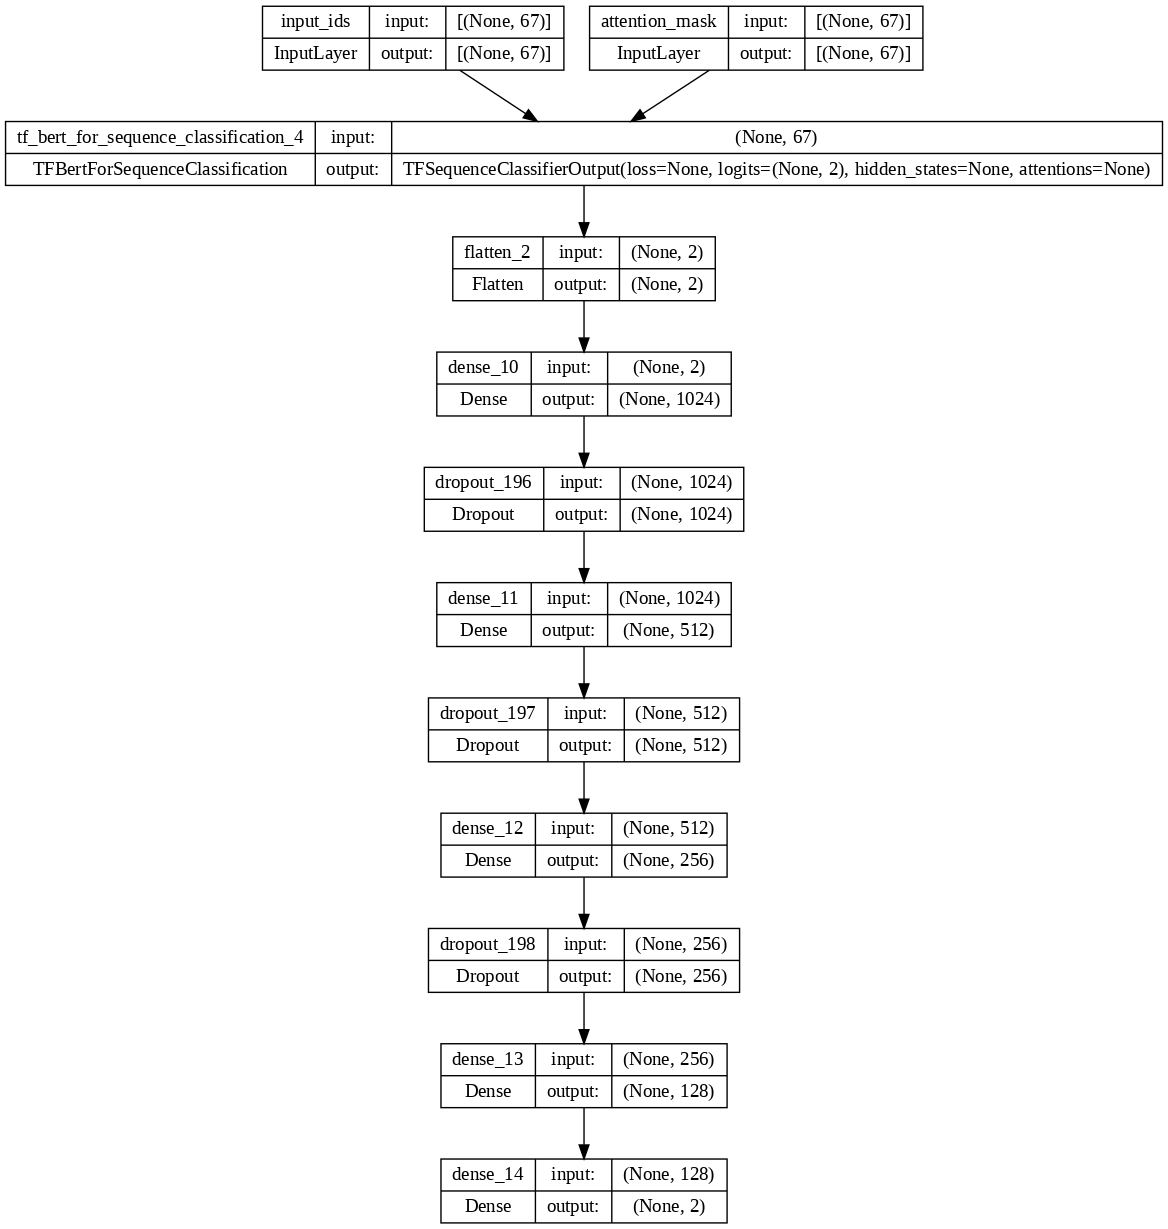

In [155]:
plot_model(model,dpi=100,show_shapes=True)

## Compiling the model

In [156]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,clipnorm=1.0)
loss = CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

## Training the fine-tuned BERT transformer model

In [157]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=3,
                   verbose=1,
                   mode='max')
filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mc = ModelCheckpoint(filepath=filepath,
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True,
                     verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=2)

In [158]:
r = model.fit(x={'input_ids': X_train['input_ids'], 
                 'attention_mask': X_train['attention_mask']},
              y=to_categorical(y_train),
              epochs=10,
              batch_size=32,
              callbacks=[es,mc,reduce_lr],
              validation_data=({'input_ids': X_test['input_ids'], 
                                'attention_mask': X_test['attention_mask']},
                               to_categorical(y_test))
             )

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9175
Epoch 1: val_accuracy improved from -inf to 0.97099, saving model to weights-01-0.97.hdf5
130/130 [==============================] - 76s 212ms/step - loss: 0.2164 - accuracy: 0.9175 - val_loss: 0.0748 - val_accuracy: 0.9710 - lr: 5.0000e-05
Epoch 2/10
130/130 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9816
Epoch 2: val_accuracy improved from 0.97099 to 0.98453, saving model to weights-02-0.98.hdf5
130/130 [==============================] - 18s 141ms/step - loss: 0.0746 - accuracy: 0.9816 - val_loss: 0.0623 - val_accuracy: 0.9845 - lr: 5.0000e-05
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9923
Epoch 3: val_accuracy did not improve from 0.98453
130/130 [==============================] - 14s 109ms/step - loss: 0.0322 - accuracy: 0.9923 - val_loss: 0.1327 - val_accuracy: 0.9739 - lr: 5.0000e-05
Epoch 4/10
130/130 [=====

## Analyzing the overall performance of the fine-tuned ROBERTA transformer model

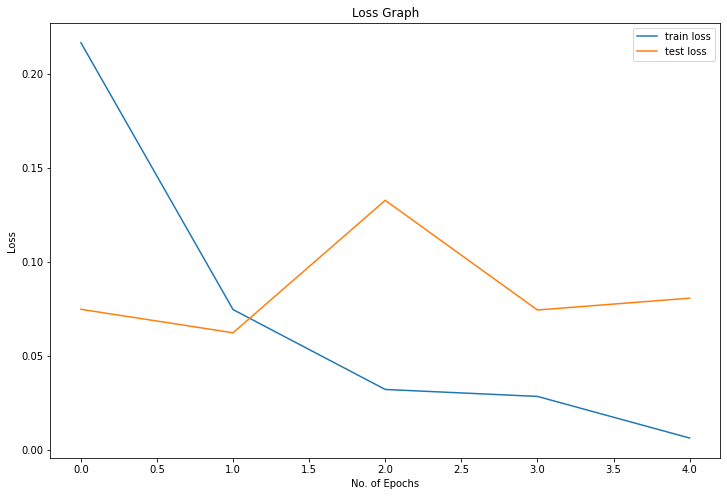

In [159]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

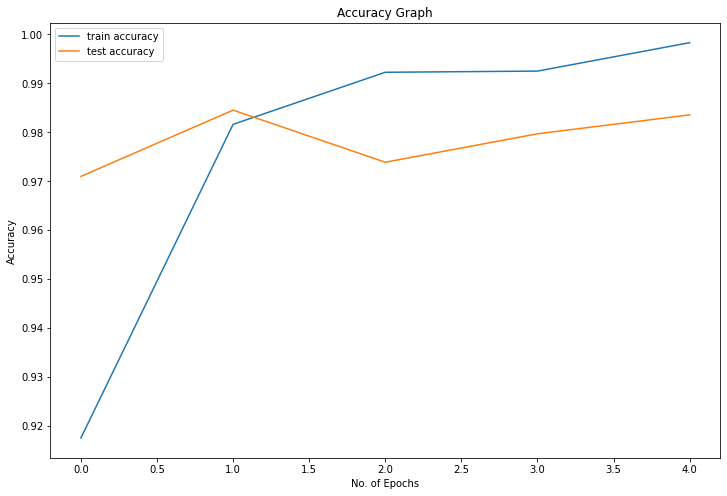

In [160]:
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'],label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [161]:
model.save(path+'sms_spam_detector.h5')

## Model Evaluation

In [162]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(y_test))
print("Test Categorical Crossentropy Loss:", loss)
print("Test Categorical Accuracy:", acc)

33/33 [==============================] - 1s 31ms/step - loss: 0.0807 - accuracy: 0.9836
Test Categorical Crossentropy Loss: 0.08069944381713867
Test Categorical Accuracy: 0.9835590124130249


In [163]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test,test_predictions))
print("Classification Report:")
print(classification_report(y_test,test_predictions))

33/33 [==============================] - 5s 31ms/step
Confusion Matrix:
[[898   5]
 [ 12 119]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.96      0.91      0.93       131

    accuracy                           0.98      1034
   macro avg       0.97      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034

